In [44]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [54]:
exp_number = 1
hwm_experiments = 3

data = np.loadtxt(f'./data/exp{exp_number}_freefall.csv', delimiter=',', skiprows=1)
data

array([[5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.16e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.16e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.34e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.17e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.17e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.00e-01, 9.00e-03],
       [5.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.17e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.83e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.67e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 4.00e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+00, 0.00e+00, 3.66e-01, 9.00e-03],
       [7.00e-01, 5.00e-04, 0.00e+

In [46]:
def error_prop_addition(*args):
    errors = np.array(args)
    return np.sqrt(np.sum(errors**2, axis=0))

def frac_error_prop_mult(*args):
    if type(args[0]) != tuple:
        raise NotImplementedError("Each parameter should be a tuple pair, \
                      where first element is A_err and second element is A")
    args_arr = np.array(args)
    errors = args_arr[:,0]
    abs_values = args_arr[:,1]
    frac_errs = errors/abs_values
    frac_err_propagation = np.sqrt(np.sum(frac_errs**2))
    return frac_err_propagation

def frac_errror_prop_power_single(A_err, A, power):
    return power*A_err/A

def frac_errror_prop_power(*args):
    # @TODO: Figure out how to vectorize this, so that user can simply put in tuples of arrays
    # of A_err, A, and pow, and get back err_propagation. Will leave for the future.
    if type(args[0]) != tuple:
        raise NotImplementedError("Each parameter should be a tuple triplet, \
                      where first element is A_i_err, second element is A_i, \
                      and third elements is n_i, and Z=multOrDiv(A^n)")
    print(*args)
    args_arr = np.array(args)
    print(args_arr)
    errors = args_arr[:,0]
    abs_values = args_arr[:,1]
    exponents = args_arr[:,1]
    frac_errs = errors/abs_values
    
    frac_err_propagation = np.sqrt(np.sum( (frac_errs*exponents)**2))
    return frac_err_propagation
    

In [47]:
# tf: time to reach ground (t subscript f)
tf = data[:,4]-data[:,2]
tf_err = error_prop_addition(data[:,5],data[:,3])
tf_sq = tf**2
#tf_sq_err = tf_sq*frac_errror_prop_power( (tf_err,tf,2) )
tf_sq_err = frac_errror_prop_power_single(tf_err, tf, 2)

heights = data[:,0]
heights_err= data[:,1]
# Ignore error in heights by now because Least Squares can't
# deal with uncertainties from multiple variables. It isn't the dominant error anyway.
print(tf_sq_err)

[0.10633185 0.10633185 0.10633185 0.10633185 0.10633185 0.10633185
 0.10012131 0.10633185 0.10633185 0.09994442 0.10633185 0.10012131
 0.10633185 0.10012131 0.10633185 0.10633185 0.09994442 0.10012131
 0.10012131 0.10012131 0.10012131 0.09459622 0.10012131 0.09459622
 0.0944383  0.09994442 0.0944383  0.0944383  0.0944383  0.0944383
 0.0944383  0.09459622 0.08880462 0.09459622 0.10012131 0.08950719
 0.08950719 0.0944383  0.08950719 0.0944383  0.0944383  0.09459622
 0.08964904 0.09459622 0.08950719 0.08950719 0.08950719 0.08950719
 0.08950719 0.08950719 0.08246143 0.08950719 0.08964904 0.08506548
 0.08964904 0.08950719 0.08506548 0.08506548 0.08493775 0.08950719]


In [48]:
def calculate_lsq_g_err(x, y, gradient, model):
    # x should be a simple np array (vector) with N entries, where x_i is a float
    # and it should be the independent variable (e.g. height)
    # y should be a simple np array (vector) with N entries, where y_i is a float
    # and it should be the dependent variable (e.g. time it took to fall, squared)
    x = x.flatten() if (len(x.shape)>1) else x
    y = y.flatten() if (len(y.shape)>1) else y
    N = len(x)
    
    y_pred = model(x, gradient)
    g = 2/gradient
    
    common_uncertainty = np.sqrt((1/(N-2)) * np.sum((y - y_pred)**2)) # magnitude of uncertainty in y-measurements
    Delta = N*np.sum(x**2) - np.sum(x)**2
    gradient_err = common_uncertainty* np.sqrt(N/Delta)
    # since g=2*gradient**(-1), then g_err/g = err_grad/grad
    g_err_frac = gradient_err/gradient
    return g_err_frac

def least_squares_fitting_predict_g(X,Y,Y_err,model=None):
    fitting_line = lambda x,m: m*x
    model = model if (model is not None) else fitting_line
    params, params_covariance = curve_fit(model, X, Y, sigma=Y_err)
    ## We only have 1 variables in the model, the gradient, so covariance matrix is 1x1
    m = params[0]
    m_var = params_covariance[0]
    
    g = 2/m
    g_err = g*calculate_lsq_g_err(X,Y,m,model)
    
    return ((g, g_err), (params, params_covariance), model)

gs, params_and_cov, model = least_squares_fitting_predict_g(heights, tf_sq, tf_sq_err)
print(f"The least squares fitting method predicted g = {gs[0]:.3f} ± {gs[1]:.3f} ms^-2.")

The least squares fitting method predicted g = 9.784 ± 0.899 ms^-2.


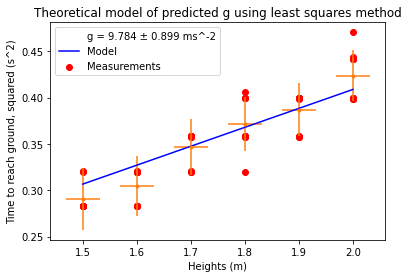

In [49]:
heights_per_exp = np.array(np.split(heights,hwm_experiments))
heights_err_per_exp = np.array(np.split(heights_err, hwm_experiments))
tf_sq_per_exp = np.array(np.split(tf_sq,hwm_experiments))
tf_sq_err_per_exp = np.array(np.split(tf_sq_err,hwm_experiments))

heights_avg_per_exp = np.average(heights_per_exp, axis=1)
heights_std_err_per_exp = 1/np.sqrt(np.sum((1/heights_err_per_exp)**2, axis=1))## Hughes and Hase,
tf_sq_avg_per_exp = np.average(tf_sq_per_exp, axis=1)
#tf_sq_std_err_per_exp = np.sqrt(np.sum(tf_sq_err_per_exp**2, axis=1))
tf_sq_std_err_per_exp = 1/np.sqrt(np.sum((1/tf_sq_err_per_exp)**2, axis=1)) ## Hughes and Hase, 

theoretical_prediction = model(heights, params_and_cov[0][0])

plt.plot([],[], ' ', label=f"g = {gs[0]:.3f} ± {gs[1]:.3f} ms^-2")
plt.scatter(heights, tf_sq, color='r', label='Measurements')
plt.plot(heights, theoretical_prediction, color='b',label='Model')

plt.xlabel("Heights (m)")
plt.ylabel("Time to reach ground, squared (s^2)")
plt.title("Theoretical model of predicted g using least squares method")
plt.legend()
plt.errorbar(heights_avg_per_exp, tf_sq_avg_per_exp, tf_sq_std_err_per_exp, heights_std_err_per_exp , fmt='.')
plt.savefig(f'./plots/model_exp{exp_number}.png',dpi=(125))